In [13]:
import numpy as np

# Imagine you have a class with a .update method, 
# args are the pose of an object and 
# your .update method gets called every time you have a new pose estimate (about 100hz)

# https://cseweb.ucsd.edu/classes/wi18/cse169-a/slides/CSE169_03.pdf

# 3d position vector
# 4x4 pose matrix: review this, as well as homogeneous coordinates.
# https://peteroupc.github.io/html3dutil/tutorial-matrixdetails.html#Why_a_4x4_Matrix

def hamilton(q1, q2):
        q_n = np.zeros(4)
        q_n[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
        q_n[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
        q_n[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
        q_n[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]
        return q_n
    
def inverse(q):
    mag = q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2 # should just be 1 bc unit quaternion.
    return mag * np.array([q[0], -q[1], -q[2], -q[3]])

class Object: # stored pose is the previous pose

    def __init__(self, stored_pose_mat, stored_pose_quat):
        self.stored_pose_mat = stored_pose_mat 
        self.stored_pose_quat = stored_pose_quat
    
    ######## In quat space ###########
    
    def angle_between_quats(self, q1, q2): # we are assuming the paramter quat 'q' is already normalized
        return 2*np.arccos(np.clip(q1@q2,a_min=-1,a_max=1))

    def axis_between_quats(self, q1, q2):
        ## finish this: rotational axis for q1 -> q2 rotation
        # import pdb; pdb.set_trace()
        q_rel = hamilton(inverse(q2), q1)
        theta = 2*np.arccos(np.clip(q_rel[0],a_min=-1,a_max=1))
        versor = q_rel[1:4]
        norm = np.linalg.norm(versor)
        if (norm != 0):
            versor = versor / np.linalg.norm(versor, 2)
        axis = versor
        return axis
    
    def update_quat(self, cur_quat):
        # import pdb; pdb.set_trace()
        theta = self.angle_between_quats(self.stored_pose_quat, cur_quat)
        axis = self.axis_between_quats(self.stored_pose_quat, cur_quat)
        self.stored_pose_quat = cur_quat
        return [theta, axis]

    ######## In rot space #############

    def angle_between_rotations(self, R1, R2):
        Rdiff = R2@np.transpose(R1) # rotation matrix required to obtain R2 from R1 (R2 = Rdiff@R1, Rdiff = R255)
        trace = np.trace(Rdiff)
        theta = np.arccos((trace - 1)/2)
        return theta
    
    def axis_between_rotations(self, R1, R2):
        # find the eigenvector, where the eigenvalue=1
        # import pdb; pdb.set_trace()
        Rdiff = np.transpose(R1)@R2
        eigs = np.linalg.eig(Rdiff)
        eigenval1 = 1 + 0j
        ind = np.where(eigs[0] == eigenval1) # identify index of rotation axis eigenvector (vector whose eigenvalue is 1)
        axis = eigs[1][:,ind[0].item()]
        return axis
    
    # will get called every time a new pose estimate arrives (~100 times/sec)
    def update_mat(self, cur_pose):
        # compute angular velocity of the object
        # so we probably need to compare the orientation of the current time step, with the previous one
        # and find the angular velocity with respect to a 3d-axis
        theta = self.angle_between_rotations(self.stored_pose_mat, cur_pose)
        axis = self.axis_between_rotations(self.stored_pose_mat, cur_pose)
        self.stored_pose_mat = cur_pose # update the stored pose matrix
        return [theta, axis] # return both as a tuple
    


## Then, do the same, but implemented efficiently in C++
    

In [14]:
# Define Rotation matrices as a proxy for Transformation pose matrices. We only need to calculate angular velocity, so no translation information is required.
# !! printing incorrect axis, check the hamilton product function.

rad45 = 45 * np.pi/180
rad20 = 20 * np.pi/180
# +45 degree rotation about the x-axis
Rx45 = np.array([[1, 0, 0], [0, np.cos(rad45), -np.sin(rad45)], [0, np.sin(rad45), np.cos(rad45)]])
# +20 degree rotation about the x-axis
Rx20 = np.array([[1, 0, 0], [0, np.cos(rad20), -np.sin(rad20)], [0, np.sin(rad20), np.cos(rad20)]])

q45x = np.array([0.9238795, 0.3826834, 0, 0]) # orientation: +45 degrees about x-axis
q20x = np.array([0.9848078, 0.1736482, 0, 0]) # orientation: +20 degrees about x-axis\

o1 = Object(Rx45, q45x)
[theta, axis] = o1.update_mat(Rx20)
# print(o1.update_mat(Rx20))
print(f'object experiences a: {theta*180/np.pi} degree rotation, about the axis {np.real(axis)}')
print(f'assuming 100 Hz, the angular velocity is {theta*100} rad/sec')

object experience a: 24.999999999999993 degree rotation, about the axis [1. 0. 0.]
assuming 100 Hz, the angular velocity is 43.633231299858224 rad/sec


In [15]:
# Perform the same operations with quaternions:

[theta, axis] = o1.update_quat(q20x)
# print(o1.update_mat(Rx20))
print(f'object experiences a: {theta*180/np.pi} degree rotation, about the axis {np.real(axis)}')
print(f'assuming 100 Hz, the angular velocity is {theta*100} rad/sec')


object experience a: 24.999992418408635 degree rotation, about the axis [1. 0. 0.]
assuming 100 Hz, the angular velocity is 43.633218067485046 rad/sec


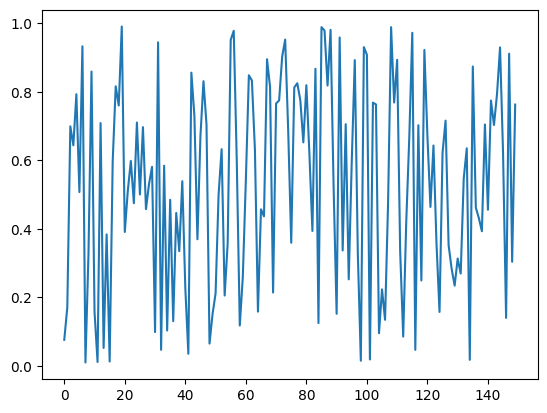

In [25]:
# Generate random data for exponential filters #

import matplotlib.pyplot as plt

data = np.random.rand(150)
plt.plot(np.arange(150), data)

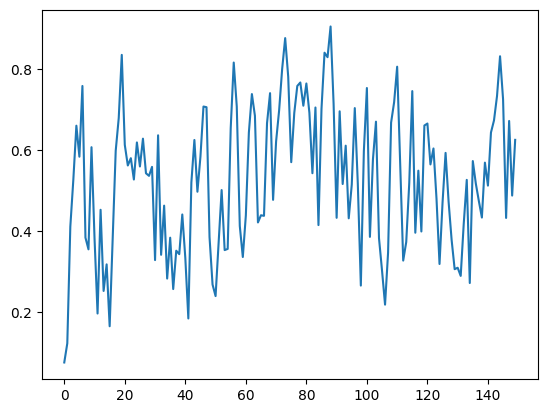

In [38]:
### Filter questions: ###
# (discrete exponential filters to filter noise in the incoming signal) #
# We apply a first order IIR filter ##

# The time constant of an exponential moving average is the amount of time for the smoothed response of a unit step function to reach 63.2% of the
# original signal.

# Let's assume first we're dealing with a single data stream, instead of the 4 channels from a quaternion

class Object:
    def __init__(self,current_data):
        self.stored_data = current_data
        self.filtered_data = current_data # for the 1st collected data point, the filter datapoint is just that of the raw data

    def update(self, new_data):
        a = 0.5 # IIR filter constant
        self.filtered_data = a*self.filtered_data + (1-a)*new_data
        self.stored_data = new_data

o1 = Object(data[0])

filtered_output = np.zeros(data.shape)
filtered_output[0] = data[0]

for i in range(1, data.shape[0]):
    o1.update(data[i])
    filtered_output[i] = o1.filtered_data

plt.plot(np.arange(data.shape[0]), filtered_output)

## Then, do the same, but implemented efficiently in c++